# Data Cleaning + Labeling Utility

## Purpose
This example provides a simple utility which will allow you to display the pictures and correct their labels, if needed.
We’re using the well-known CIFAR-10 dataset. We’ve extracted the features of this dataset using ResNest18. We then introduce noise to this dataset, by mislabeling some of the data instances of the train dataset. In the next step, we clean the data using coresets. Cleaning the data using coresets is simple and requires only a few lines of code. We first instantiate the CoresetTreeServiceLG class while optimized_for='cleaning' and build the Coreset service tree using the build function. Then in each cleaning iteration, we call the get_important_samples function, to retrieve samples that have high importance, which usually indicates a labeling error or other anomaly, from the classes we are interested in. In each iteration we also call update_targets to update the labels of the mislabeled samples.
Each sample/picture is then displayed using the utility and it is possible to correct the label by selecting a different label from the existing list, creating a new label if the right label is not on the list or just approving the existing label if it is correct.
As can be seen, coresets is a great way to clean data. The same methodology can be easily applied to your dataset too.

In [1]:
%%capture
!pip install gdown

In [2]:
import copy
import pathlib
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from dataheroes import CoresetTreeServiceLG

In [3]:
# Ignore convergence warnings for logistic regression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Load CIFAR10 Dataset

In [4]:
import shutil
import gdown
# public folder on Google drive with data and images
url = "https://drive.google.com/drive/folders/1UVcEEYL3mBnazAjRGWetR44P81VFQ5DA"
# create local data folder
data_path = pathlib.Path('../data/cifar10_resnet18/generated')
data_path.mkdir(parents=True, exist_ok=True)
# download files
gdown.download_folder(url, quiet=True, use_cookies=False, output=str(data_path))
# unpack images
shutil.unpack_archive(str(data_path / "images.tar.gz"), str(data_path))
# load data to the memory
X_train = np.load(str(data_path / "x_train.npy"))
X_test = np.load(str(data_path / "x_test.npy"))
y_train = np.load(str(data_path / "y_train.npy"))
y_test = np.load(str(data_path / "y_test.npy"))

## Initialize a logistic regression classifier
We've set max_iter to 500 to get better convergence. Reduce this number to speed up the runtime.

In [5]:
clf_params = {"class_weight": "balanced", "max_iter": 500}
clf = LogisticRegression(**clf_params)

## Ignore convergence warnings

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

## Define the evaluation method

In [7]:
def eval_clf(y_train_to_eval):
    clf.fit(X_train, y_train_to_eval)
    return roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr")

## Evaluate model on the clean data

In [8]:
score_clean = eval_clf(y_train)

## Select the classes to mislabel
We’re selecting 3 classes from which we’re then going to randomly select samples to be mislabeled.
The 3 selected classes are the ones in which the prediction model missed mostly, based on the confusion matrix.

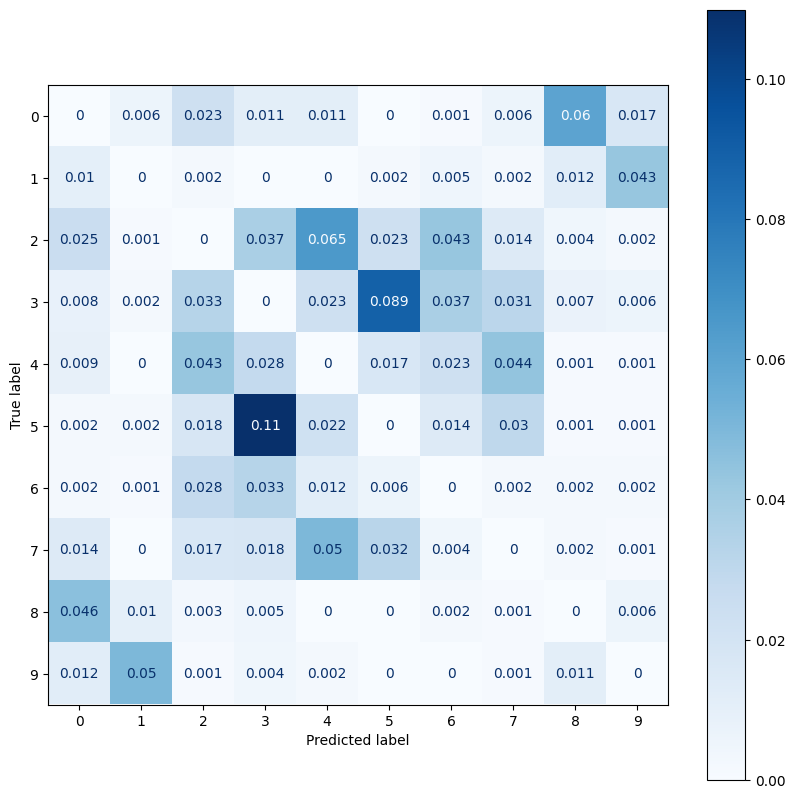

classes_transform=[(5, 3), (3, 5), (2, 4)]


In [9]:
n_weak_cls = 3
classes_transform = []
clf.fit(X_train, y_train)
cm = confusion_matrix(y_test, clf.predict(X_test), normalize="true")
np.fill_diagonal(cm, 0)
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot(cmap = "Blues", ax = ax)
plt.show()
for _ in range(n_weak_cls):
    # Select the cell with the highest value.
    from_to = np.where(cm == cm.max())
    # First element in the from_to tuple is the correct label and the second element is the predicted label.
    classes_transform.append((from_to[0][0], from_to[1][0]))
    # Set to zero so that it won't be chosen on the next iteration.
    cm[from_to[0], from_to[1]] = 0
print(f'{classes_transform=}')

## Add some noise to y_train
Change some of the labels in y_train (mislabel).

In [10]:
noise_amount = 600
noise_amount_per_class = noise_amount // len(classes_transform)
y_train_noise_orig = copy.deepcopy(y_train)
for from_class, to_class in classes_transform:
    y_from_ind = np.where(y_train_noise_orig == from_class)[0]
    np.random.shuffle(y_from_ind)
    y_train_noise_orig[y_from_ind[:noise_amount_per_class]] = to_class

mislabeled_classes = [c[1] for c in classes_transform]

## Evaluate before cleaning

In [11]:
score_before_cleaning = eval_clf(y_train_noise_orig)

## Set cleaning params

In [12]:
n_iterations = 5
n_samples_per_iter = 20
# Define for each class how many samples to fix in each iteration.
# The amount takes into consideration the times a class appears in mislabeled_classes
classes, counts = np.unique(mislabeled_classes,return_counts=True)
counts = counts * n_samples_per_iter//len(mislabeled_classes)
samples_per_class = dict(zip(classes, counts))
print(f'{samples_per_class=}')

samples_per_class={3: 6, 4: 6, 5: 6}


## Clean data using the coreset service

In [13]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import matplotlib.image as mpimg
import glob

# Suppose this map should be generated on previous step and be taken from file.
image_label_map = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 
             5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

def show_image(original_idx):
    plt.figure(figsize=(1,1))
    images_path = data_path.joinpath('images/train')
    for image_name in glob.glob(f'{images_path}/train_{original_idx:06}*.png'):
        plt.imshow(mpimg.imread(image_name))
        plt.axis('off')
        plt.show()
    
n_real_samples_per_iter = sum([samples_per_class[cls] for cls in samples_per_class])
current_iteration = -1
important_samples = np.array([]).astype(int)
coreset_result = {'score': [score_before_cleaning], 'fixed': [0], 'viewed': [0]}
y_train_noise = copy.deepcopy(y_train_noise_orig)
viewed_indices = np.array([]).astype(int)
dataset_indices = np.arange(0, len(X_train), dtype=int)

service = CoresetTreeServiceLG(optimized_for='cleaning')
service.build(X_train, y_train_noise, indices=dataset_indices)

def before_iteration():
    global viewed_indices, important_samples
    # Returns indices of most important samples order by importance.
    result = service.get_important_samples(
        class_size=samples_per_class,
    )
    
    important_samples = result['idx']
    viewed_indices = np.concatenate([viewed_indices, important_samples])

def after_iteration():
    global viewed_indices, important_samples

    service.update_targets(
        indices=important_samples,
        y=y_train_noise[important_samples],
    )
    
    score = eval_clf(y_train_noise)
    mislabeled = np.sum(y_train_noise != y_train)
    fixed = np.sum(y_train_noise != y_train_noise_orig)
    coreset_result['score'].append(score)
    coreset_result['fixed'].append(fixed)
    coreset_result['viewed'].append(len(viewed_indices))
    
def show_ui(iteration, index_in_interation):
    global current_iteration, important_samples
    if iteration > current_iteration:
        clear_output()
        display(Markdown(f'# Preparing data {iteration+1} of {n_iterations}...'))
        before_iteration()
        current_iteration += 1
    else:
        start_idx = iteration * n_real_samples_per_iter
        important_samples = viewed_indices[start_idx: start_idx + n_real_samples_per_iter ]
    clear_output() 
    original_index = important_samples[index_in_interation]
    display(Markdown(f'# Iteration {iteration+1} of {n_iterations}'))
    display(Markdown(f'# Image {index_in_interation+1} of {len(important_samples)}'))
    show_image(original_index)
    
    new_label = widgets.Text(description='Create new label:')
    new_label.style = {'description_width': '150px'}
    
    dropdown = widgets.Select(
        options= [image_label_map[i] for i in image_label_map],
        rows=10,
        value=image_label_map[y_train_noise[original_index]],
        description='Label:',
        )
    dropdown.style = {'description_width': '150px'}
    button_approve = widgets.Button(description='Approve')
    button_back = widgets.Button(description='Back')

    def on_button_approve(b):
        if new_label.value != '' and new_label.value not in [image_label_map[i] for i in image_label_map]:
            image_label_map[len(image_label_map)] = new_label.value
        y_train_noise[original_index] = [image_label_map[i] for i in image_label_map].index(dropdown.value)
        if index_in_interation < len(important_samples) - 1:
            show_ui(iteration, index_in_interation+1)
        else:
            clear_output()
            display(Markdown(f'# Evaluating model {iteration+1} of {n_iterations}...'))
            after_iteration()
            if iteration+1 == n_iterations:
                clear_output()
                display(Markdown('# All pictures have been examined'))
            else:
                show_ui(iteration+1, 0)

    def on_button_back(b):
        global important_samples
        if index_in_interation > 0:
            show_ui(iteration, index_in_interation-1)
        elif iteration > 0:
            start_idx = (iteration-1) * n_real_samples_per_iter
            important_samples = viewed_indices[start_idx: start_idx + n_real_samples_per_iter ]
            show_ui(iteration-1, len(important_samples)-1)
                
    button_approve.on_click(on_button_approve)
    button_back.on_click(on_button_back)
    display(dropdown, new_label, button_approve, button_back)

show_ui(0, 0)

# All pictures have been examined

## Plot AUC chart

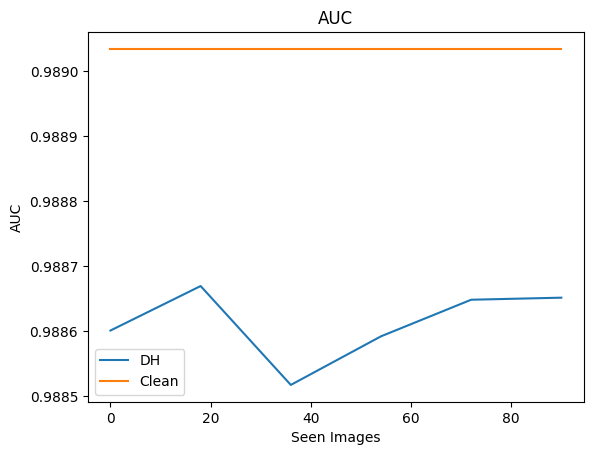

In [16]:
plt.plot(coreset_result["viewed"],coreset_result["score"], label="DH")
plt.plot(coreset_result["viewed"], np.ones(len(coreset_result["viewed"])) * score_clean, label="Clean")
plt.ylabel("AUC")
plt.xlabel("Seen Images")
plt.title("AUC")
plt.legend()
plt.show()

## Plot Fixed chart

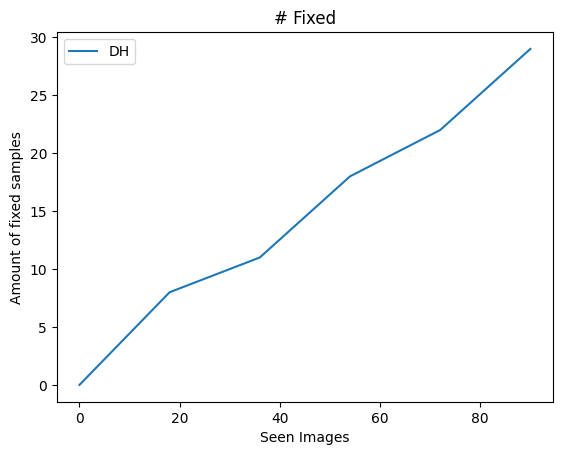

In [17]:
plt.plot(coreset_result["viewed"], coreset_result["fixed"], label="DH")
plt.ylabel("Amount of fixed samples")
plt.xlabel("Seen Images")
plt.title("# Fixed")
plt.legend()
plt.show()